## Linear Regression with Pytorch
- The aim here is to start with a simple linear regression on some random data using Pytorch

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchinfo import summary

In [12]:
x = np.linspace(-1, 1, 100)
y = 3*x**2 - 2*x + 1 + 2*np.random.normal(0, 0.3, x.shape)

### The PyTorch model (classes and inheritance)
- In PyTorch, when we want to create a specific NN we create a class. This class tends to be a subclass of the generic class `nn.Module`, which why we write `class ourModel(nn.Module):`. In doing so we are inheriting from the base class `nn.Module`. This will allow us to call other methods in `nn.Module` which are not specified in our class.
- As always in Python, the class must contain an `__init__` method which is called when an instance of the class is created. We will then always start with the line `super(ourModel, self).__init__()`. This is calling the init method in the parent class. We then specify what components we will need in our model. Hence, we set up the attributes we want, eg: in the case below we include a linear layer which will be used afterwards in the forward method. 

In [13]:
class SimpleReg(nn.Module):
    def __init__(self):
        super(SimpleReg, self).__init__()
        self.fc = nn.Linear(1, 1)

    def forward(self, x):
        x = self.fc(x)
        return x

    def reset_weights(self):
        # Reset the weights of the linear layer
        self.fc.reset_parameters()

model = SimpleReg()

In [14]:
summary(model)

Layer (type:depth-idx)                   Param #
SimpleReg                                --
├─Linear: 1-1                            2
Total params: 2
Trainable params: 2
Non-trainable params: 0

In [15]:
(X_train,  
 X_test,
 Y_train, 
 Y_test) = train_test_split(x,
                            y,
                            test_size=0.2,
                            random_state=1)

# Convert numpy arrays to PyTorch tensors
# the .view is needed because PyTorch expects a 2D tensor
# with the first dimension being the number of samples
# and the second dimension being the number of features
X_train = torch.tensor(X_train, dtype=torch.float32).view(-1, 1)
Y_train = torch.tensor(Y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32).view(-1, 1)
Y_test = torch.tensor(Y_test, dtype=torch.float32).view(-1, 1)


### Training
Let's briefly explain some lines in the code:
- During a forward pass, all operations performed on the input tensors are stored. These operations are stored on nodes in a *computational graph*. 
- When `loss.backward()` is called, PyTorch computes the gradients of the loss with respect to each parameter in the model by traversing this computational graph in reverse (backpropagation). Each parameter in `model.parameters()` will have a `.grad` attribute in which the gradient is stored.
- The `optimizer.step()` updates the model parameters using the computed gradients.
- Also, `loss = criterion(y_pred, Y_train)` is a tensor with a single scalar value. The method `.item()` extracts that scalar and converts it into a Python float.

In [16]:
# Loss function and optimiser
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
model.reset_weights()

# Training loop
for epoch in range(10000):
    optimizer.zero_grad() # sets greadients to 0
    y_pred = model(X_train)
    loss = criterion(y_pred, Y_train)
    loss_test = criterion(model(X_test), Y_test)
    loss.backward() # backpropagation
    optimizer.step()
    if epoch % 1000 == 0:
        print(f'Epoch {epoch} training loss: {loss.item()}, testing loss: {loss_test.item()}')

Epoch 0 training loss: 10.109166145324707, testing loss: 5.556430339813232
Epoch 1000 training loss: 1.0517301559448242, testing loss: 0.9483491778373718
Epoch 2000 training loss: 1.0517284870147705, testing loss: 0.948699951171875
Epoch 3000 training loss: 1.0517284870147705, testing loss: 0.948699951171875
Epoch 4000 training loss: 1.0517284870147705, testing loss: 0.948699951171875
Epoch 5000 training loss: 1.0517284870147705, testing loss: 0.948699951171875
Epoch 6000 training loss: 1.0517284870147705, testing loss: 0.948699951171875
Epoch 7000 training loss: 1.0517284870147705, testing loss: 0.948699951171875
Epoch 8000 training loss: 1.0517284870147705, testing loss: 0.948699951171875
Epoch 9000 training loss: 1.0517284870147705, testing loss: 0.948699951171875


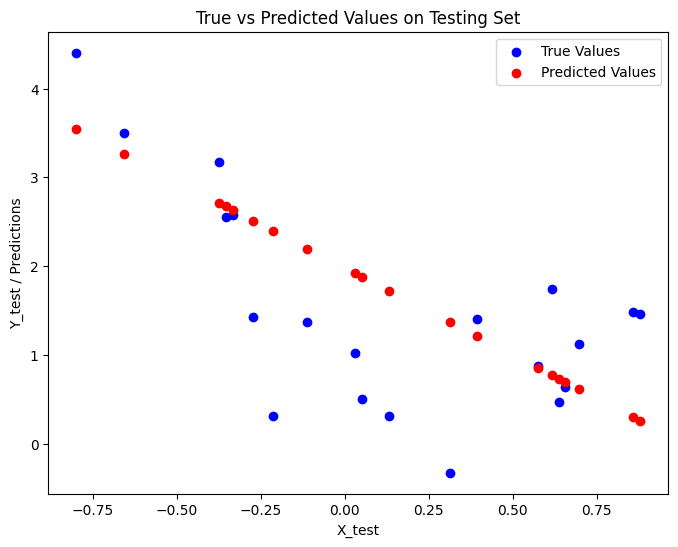

In [17]:
# Generate predictions on the testing set
y_pred_test = model(X_test).detach().numpy()

# Plot true vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(X_test.numpy(), Y_test.numpy(), color='blue', label='True Values')
plt.scatter(X_test.numpy(), y_pred_test, color='red', label='Predicted Values')
plt.xlabel('X_test')
plt.ylabel('Y_test / Predictions')
plt.title('True vs Predicted Values on Testing Set')
plt.legend()
plt.show()

## Polynomial regression
- How can we extend the model to include polynomial regression?

In [18]:
class PolynomialReg(nn.Module):
    def __init__(self, degree=2):
        super(PolynomialReg, self).__init__()
        self.degree = degree
        self.fc = nn.Linear(degree, 1)  # Adjust input features to match the degree

    def forward(self, x):
        # Create polynomial features
        poly_features = torch.cat([x**i for i in range(1, self.degree + 1)], dim=1)
        return self.fc(poly_features)

    def reset_weights(self):
        # Reset the weights of the linear layer
        self.fc.reset_parameters()

In [19]:
poly_model = PolynomialReg(degree=2)
# Loss function and optimiser
criterion = nn.MSELoss()
optimizer = optim.SGD(poly_model.parameters(), lr=0.01)
poly_model.reset_weights()

# Training loop
for epoch in range(100):
    optimizer.zero_grad() # sets greadients to 0
    y_pred = poly_model(X_train)
    loss = criterion(y_pred, Y_train)
    loss_test = criterion(poly_model(X_test), Y_test)
    loss.backward() # backpropagation
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch} training loss: {loss.item()}, testing loss: {loss_test.item()}')

Epoch 0 training loss: 5.311463356018066, testing loss: 2.9929003715515137
Epoch 10 training loss: 3.7895114421844482, testing loss: 2.044346570968628
Epoch 20 training loss: 2.798398971557617, testing loss: 1.4744460582733154
Epoch 30 training loss: 2.1456661224365234, testing loss: 1.1333807706832886
Epoch 40 training loss: 1.709557294845581, testing loss: 0.929524302482605
Epoch 50 training loss: 1.4129236936569214, testing loss: 0.807174026966095
Epoch 60 training loss: 1.206775426864624, testing loss: 0.7327142953872681
Epoch 70 training loss: 1.059912919998169, testing loss: 0.6860419511795044
Epoch 80 training loss: 0.9523874521255493, testing loss: 0.6552697420120239
Epoch 90 training loss: 0.8713769912719727, testing loss: 0.6334683299064636


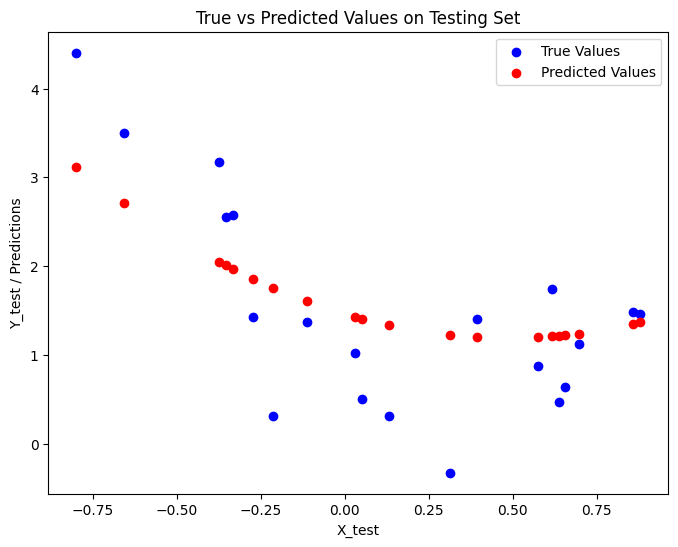

In [20]:
y_pred_test = poly_model(X_test).detach().numpy()

# Plot true vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(X_test.numpy(), Y_test.numpy(), color='blue', label='True Values')
plt.scatter(X_test.numpy(), y_pred_test, color='red', label='Predicted Values')
plt.xlabel('X_test')
plt.ylabel('Y_test / Predictions')
plt.title('True vs Predicted Values on Testing Set')
plt.legend()
plt.show()

### Convergence of stochastic gradient descent in regression models
- Notice that we are trying to minimise MSE, so the global optimiser will be given by the OLS estimator. Here we are fitting a polynomial regression (so it's the same model), but we are optimising through gradient descent. Can we say something about the convergence?
- Let our model be $Y = X\beta + \varepsilon$. The OLS estimator minimises the squared loss: 
$$ L(\beta) = \frac{1}{2n}||X\beta - y ||^2,$$
which has a closed form solution under reasonable conditions:
$$ \hat{\beta}_{OLS} = (X^TX)^{-1}X^Ty.$$
- Now, gradient descent optimises applying the formula
$$\beta^{(t+1)} = \beta^{(t)} - \eta \nabla L(\beta^{(t)},$$
where the gradient of the loss function is given by
$$ \nabla L(\beta) = \frac{1}{n}X^T(X\beta - y).$$ 
- Therefore, we can write the error at time $t+1$ as
$$\beta^{(t+1)} - \beta_{OLS} = (I-\eta H)(\beta^{(t)} - \beta_{OLS}),$$
where $H=\frac{1}{n}X^TX$ is the Hessian matrix. Hence, for an $\eta$ small enough (related to the eigenvalues of the Hessian), we will get convergence. 

## Linear Regression with sklearn
- Of course, if you're only trying to do a polynomial regression or other simple models, it might be better to just use `sklearn`. Here we briefly show how:

Linear Regression training loss: 1.05172860622406, testing loss: 0.9487005472183228


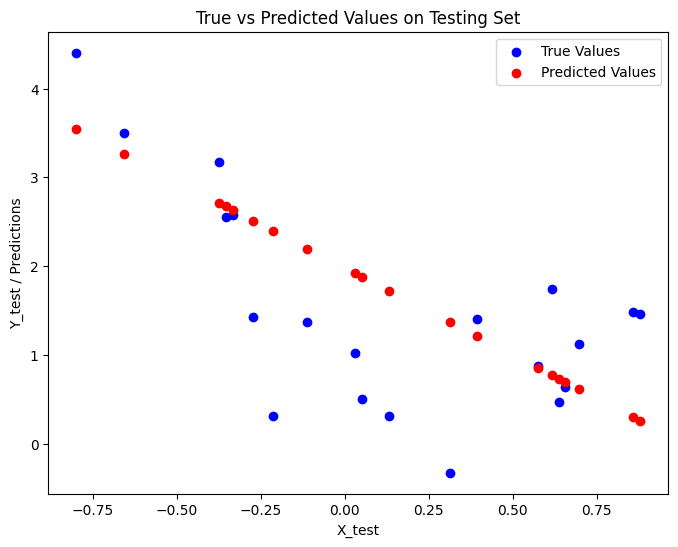

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

linear_model = LinearRegression()
linear_model.fit(X_train, Y_train)
Y_train_predict = linear_model.predict(X_train)
Y_test_predict = linear_model.predict(X_test)
linear_train_loss = mean_squared_error(Y_train, Y_train_predict)
linear_test_loss = mean_squared_error(Y_test, Y_test_predict)
print(f'Linear Regression training loss: {linear_train_loss}, testing loss: {linear_test_loss}')

plt.figure(figsize=(8, 6))
plt.scatter(X_test.numpy(), Y_test.numpy(), color='blue', label='True Values')
plt.scatter(X_test.numpy(), Y_test_predict, color='red', label='Predicted Values')
plt.xlabel('X_test')
plt.ylabel('Y_test / Predictions')
plt.title('True vs Predicted Values on Testing Set')
plt.legend()
plt.show()

`sklearn` makes it very easy to create a pipeline in which we fit different regression models for different polynomial degrees and observe how the training and testing error vary.

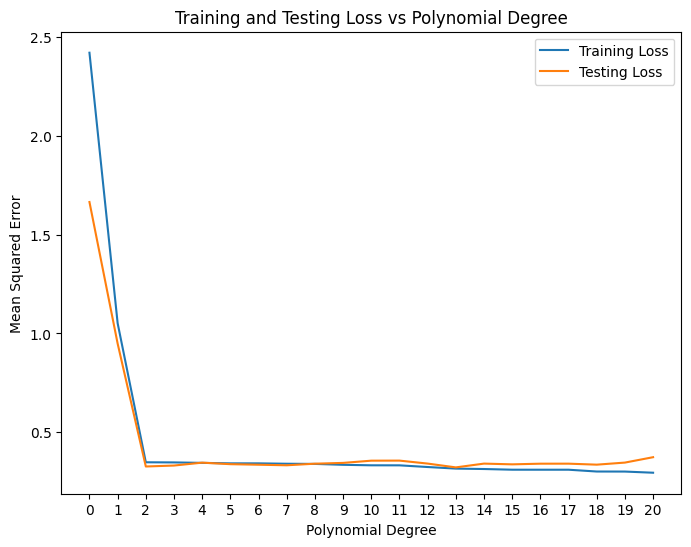

In [22]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

num_degrees = 20
degrees = np.arange(num_degrees+1)
training_loss, testing_loss = [], []

for degree in degrees:
    poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    poly_model.fit(X_train, Y_train)
    training_loss.append(mean_squared_error(Y_train, poly_model.predict(X_train)))
    testing_loss.append(mean_squared_error(Y_test, poly_model.predict(X_test)))

plt.figure(figsize=(8, 6))
plt.plot(degrees, training_loss, label='Training Loss')
plt.plot(degrees, testing_loss, label='Testing Loss')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error')
plt.title('Training and Testing Loss vs Polynomial Degree')
plt.xticks(degrees)
plt.legend()
plt.show()
